# Types of recommendation systems:


- Collaborative filtering model: 
    - Based on feedbacks: 
        - explicit feedback(ratings, thumbup/thumdown) 
        - implicit feedback(book in shopping cart, numbner of episode watched in a TV show)
    - User-user similarities (people like you, also like "The Hobbit")
    - Item-item similarities (if you like "The Hobbit", you will also "The Lord of Rings")
    - User-item similarities : combined both approaches above and use *matrix facotrization* -> Best trained with Singular Value decomposition (SVD) 


- Content-based model:
    - similarities are calculated based on content based features (like the genre, duration of the movie )
     

- Hybrid recommender model:
    - combined collaborative filtering with content-based
    - Because Hybrid Deep Learning algorithms are non-linear, they are less prone to over-simplify a user’s tastes. They allow us to learn much finer interactions between users and items. 
    - Deep learning models can reveal more complex tastes over cross-domain data (predict a user's taste on music, movies and even dishes!?)


# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation
from sklearn.metrics.pairwise import pairwise_distances

import warnings
warnings.filterwarnings('ignore')

import os, sys
import re
from contextlib import contextmanager

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords, RegexpTokenizer

[nltk_data] Downloading package punkt to /Users/jennytang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jennytang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jennytang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# display full text in columns
pd.set_option('display.max_colwidth', -1)

In [3]:
ls

BookRecommender/
Book_Crossing_Recommendation_System.ipynb
Code/
CompPhys-wk01-1_Intro_Students.ipynb
CompPhys-wk01-2_Variables_Loops_Students.ipynb
Lab2.ipynb
MovieLens_Recommender_System.ipynb
RL - Solving a maze.ipynb
RL MountainCar.ipynb
conversationalstyles/
data/
planck.pdf
test.pdf


# Load Data

to download book crossing data: http://www2.informatik.uni-freiburg.de/~cziegler/BX/

In [4]:
books = pd.read_csv('BookRecommender/data/BX-CSV-Dump/BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
users = pd.read_csv('BookRecommender/data/BX-CSV-Dump/BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']
ratings = pd.read_csv('BookRecommender/data/BX-CSV-Dump/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


In [5]:
books.info(), users.info(), ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ISBN               271360 non-null  object
 1   bookTitle          271360 non-null  object
 2   bookAuthor         271359 non-null  object
 3   yearOfPublication  271360 non-null  object
 4   publisher          271358 non-null  object
 5   imageUrlS          271360 non-null  object
 6   imageUrlM          271360 non-null  object
 7   imageUrlL          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   userID    278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ 

(None, None, None)

# Clean Data & EDA

### Book data

In [6]:
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0060973129.01.LZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0374157065.01.LZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0393045218.01.LZZZZZZZ.jpg


In [7]:
# remove image columns
books.drop(['imageUrlS', 'imageUrlM', 'imageUrlL'],axis=1,inplace=True)
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [8]:
books.yearOfPublication.unique()
# col mixed with string and int

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [9]:
books.loc[(books.yearOfPublication == 'DK Publishing Inc') | (books.yearOfPublication == 'Gallimard'), :]
# cols have shifted 

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg


In [10]:
books.loc[books.ISBN == '078946697X','yearOfPublication'] = 2000
books.loc[books.ISBN == '078946697X','bookAuthor'] = "Michael Teitelbaum"
books.loc[books.ISBN == '078946697X','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '078946697X','bookTitle'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

In [11]:
books.loc[books.ISBN == '0789466953','yearOfPublication'] = 2000
books.loc[books.ISBN == '0789466953','bookAuthor'] = "James Buckley"
books.loc[books.ISBN == '0789466953','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '0789466953','bookTitle'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

In [12]:
books.loc[books.ISBN == '2070426769','yearOfPublication'] = 2003
books.loc[books.ISBN == '2070426769','bookAuthor'] = "Jean-Marie Gustave Le ClÃ?Â©zio"
books.loc[books.ISBN == '2070426769','publisher'] = "Gallimard"
books.loc[books.ISBN == '2070426769','bookTitle'] = "Peuple du ciel, suivi de 'Les Bergers"

In [13]:
#convert some year dtype from string to int
books.yearOfPublication = pd.to_numeric(books.yearOfPublication, errors='coerce', downcast="integer")
print(sorted(books.yearOfPublication.unique()))

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


Text(0, 0.5, 'year of publication')

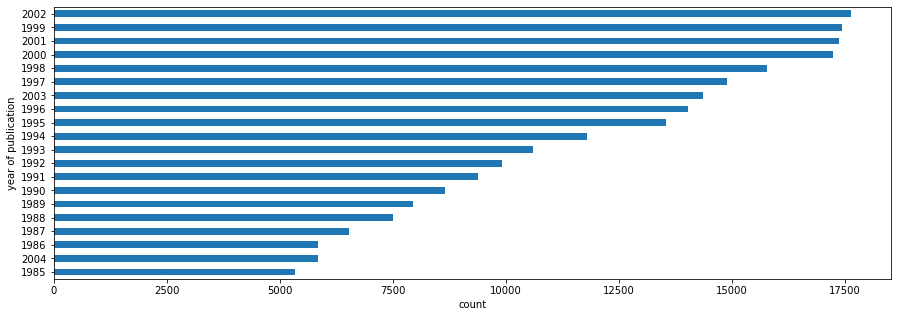

In [14]:
books.yearOfPublication.value_counts(ascending=True).tail(20).plot(kind='barh', figsize=(15, 5))
plt.xlabel("count")
plt.ylabel("year of publication")

In [15]:
# year between 1800 and 2022 is valid, which is 98% of the data 
books.loc[(books.yearOfPublication > 0) & (books.yearOfPublication <= 2022)].shape[0] / books.shape[0]

0.9829341096698113

In [16]:
books_filtered = books[(books.yearOfPublication > 0) & (books.yearOfPublication <= 2022)]
books_filtered 

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company
...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm)
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books
271357,006008667X,Lily Dale : The True Story of the Town that Talks to the Dead,Christine Wicker,2004,HarperSanFrancisco
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press


In [17]:
#strip leading and trail spaces in book titles
books_filtered.bookTitle = books_filtered.bookTitle.str.strip()

In [18]:
#cast dtype
books_filtered.ISBN.astype(str)
books_filtered.bookTitle.astype(str)
books_filtered.bookAuthor.astype(str)
books_filtered.bookAuthor.astype(str)

#drop 1 null value in bookAuthor and 2 null value in publisher
books_filtered = books_filtered[(~books_filtered.bookAuthor.isnull()) & (~books_filtered.publisher.isnull())]
books_filtered

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company
...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm)
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books
271357,006008667X,Lily Dale : The True Story of the Town that Talks to the Dead,Christine Wicker,2004,HarperSanFrancisco
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press


### User data

In [19]:
users.head()

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [20]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   userID    278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [21]:
print(sorted(users.Age.unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

In [22]:
users.loc[(users.Age > 100) | (users.Age < 10), 'Age'] = np.nan
users.Age.mean()

34.77712242216236

In [23]:
#replacing NaNs with user age mean, so we can still use the ratings 
users.Age = users.Age.fillna(users.Age.mean())

In [24]:
users.Age = users.Age.astype(np.int32)
users.Location = users.Location.astype(str)
users.userID = users.userID.astype(str)

Text(0, 0.5, 'age')

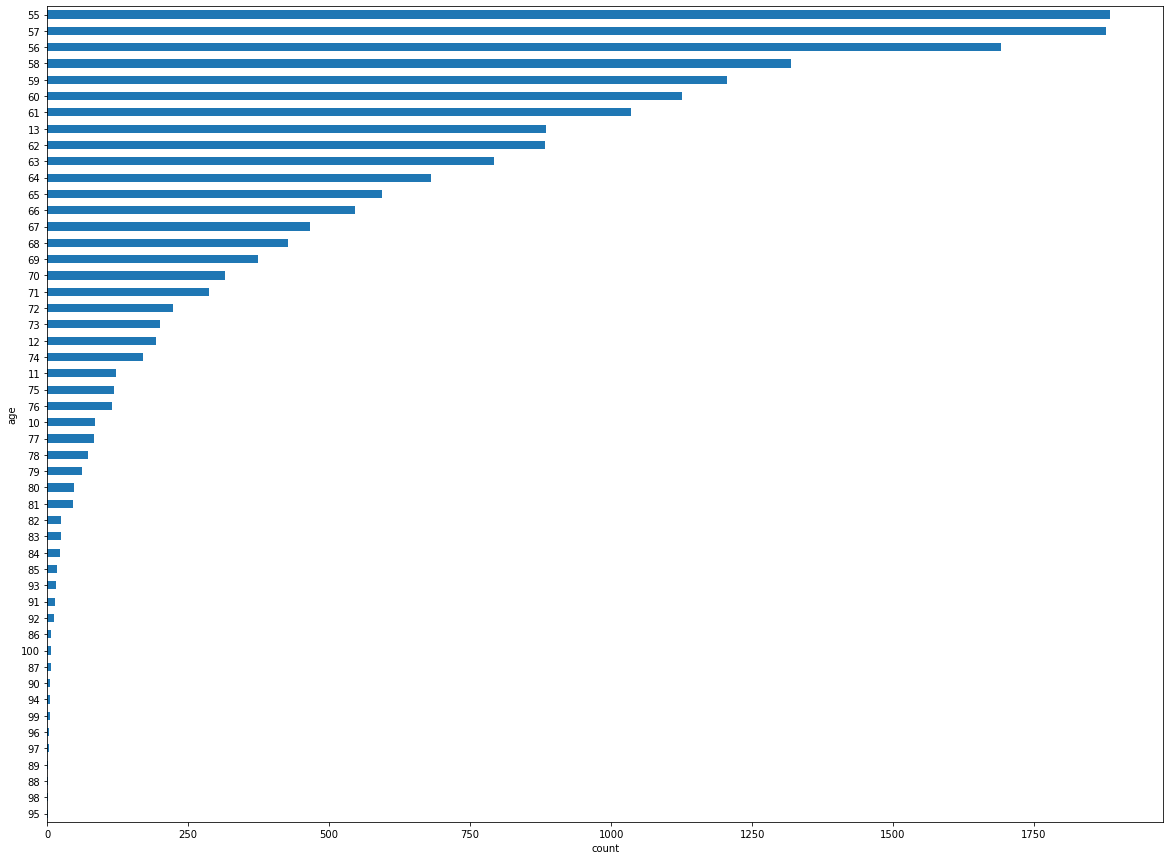

In [25]:
users.Age.value_counts(ascending=True).head(50).plot(kind='barh', figsize=(20, 15))
plt.xlabel("count")
plt.ylabel("age")

In [26]:
users.Location.nunique()

57339

In [27]:
users.Location.value_counts()

london, england, united kingdom                  2506
toronto, ontario, canada                         2250
sydney, new south wales, australia               1744
melbourne, victoria, australia                   1708
portland, oregon, usa                            1629
                                                 ... 
gneisenaustr. 3, nordrhein-westfalen, germany    1   
-, bayern, germany                               1   
bouchegouf, guelma, algeria                      1   
indiana and philadelphia, pennsylvania, usa      1   
tacoma, washington, united kingdom               1   
Name: Location, Length: 57339, dtype: int64

In [28]:
users[users.Location == ("n/a, n/a, n/a")]

,userID,Location,Age
3095,3096,"n/a, n/a, n/a",34
10646,10647,"n/a, n/a, n/a",34
11675,11676,"n/a, n/a, n/a",34
61592,61593,"n/a, n/a, n/a",34
70062,70063,"n/a, n/a, n/a",34
86150,86151,"n/a, n/a, n/a",60
119402,119403,"n/a, n/a, n/a",15
123570,123571,"n/a, n/a, n/a",34
184324,184325,"n/a, n/a, n/a",34
238301,238302,"n/a, n/a, n/a",30


Text(0, 0.5, 'location')

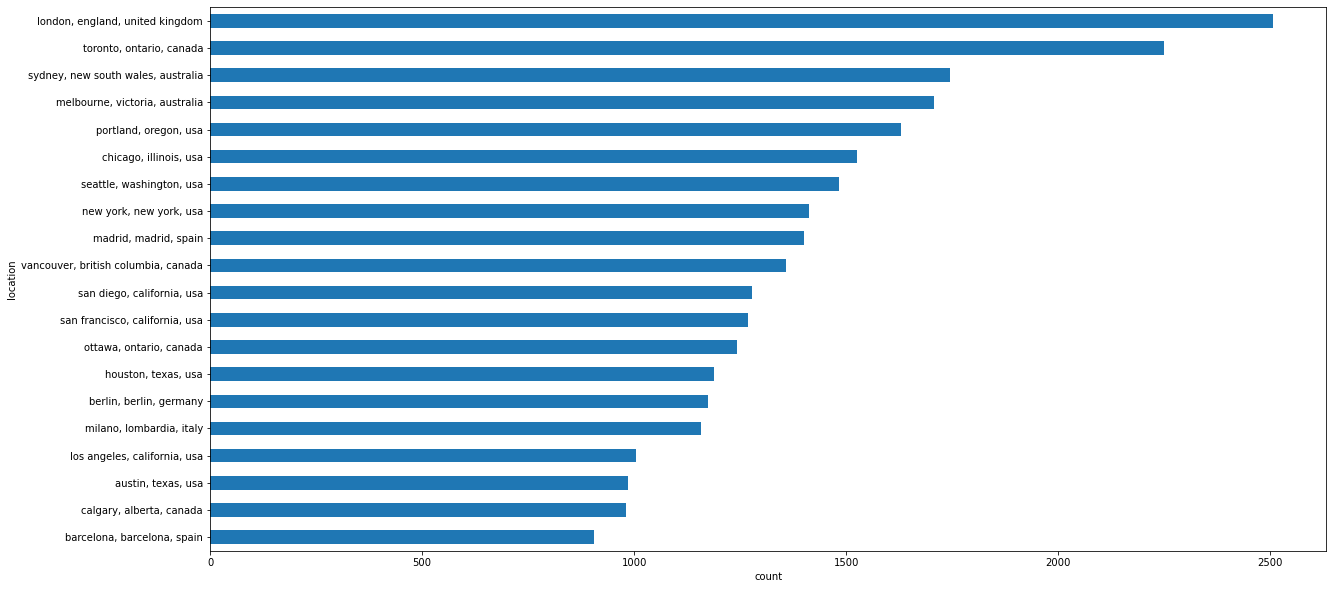

In [29]:
users.Location.value_counts(ascending=True).tail(20).plot(kind='barh', figsize=(20, 10))
plt.xlabel("count")
plt.ylabel("location")

### Rating data

In [30]:
ratings.head()

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [31]:
ratings.info() #no nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   userID      1149780 non-null  int64 
 1   ISBN        1149780 non-null  object
 2   bookRating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [32]:
ratings.userID = ratings.userID.astype(str)

Text(0, 0.5, 'User ID')

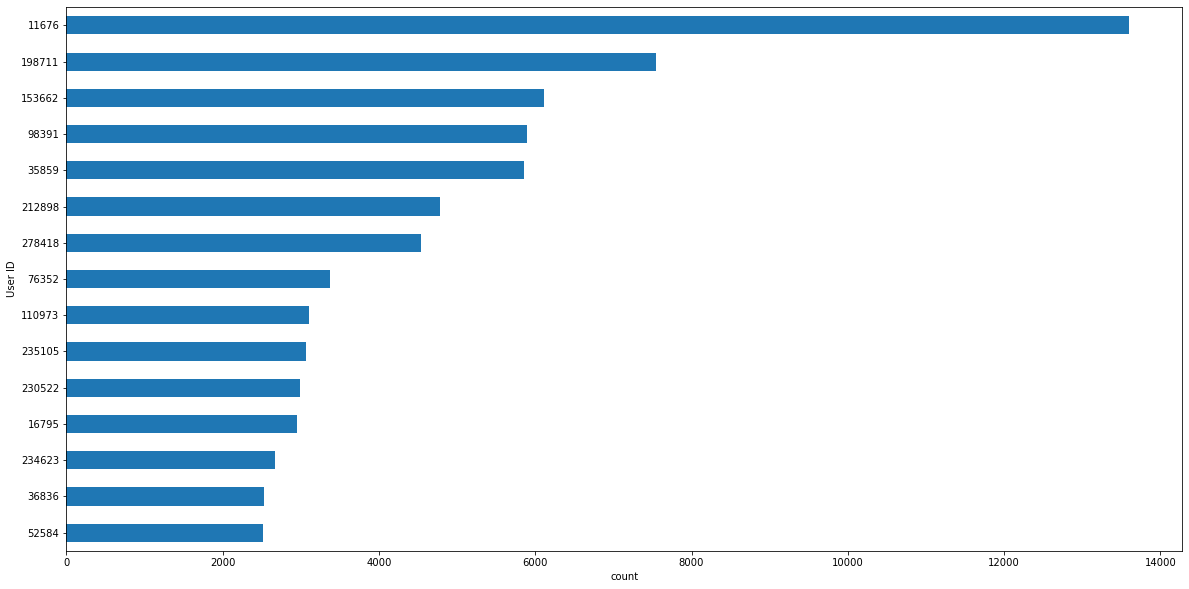

In [33]:
# who are the users give the most ratings?
ratings.userID.value_counts(ascending = True).tail(15).plot(kind='barh', figsize=(20, 10))
plt.xlabel("count")
plt.ylabel("User ID")

In [34]:
ratings[ratings.userID == '11676'].ISBN.nunique(), ratings[ratings.userID == '11676'].ISBN.count()
## ALL unique books

(13602, 13602)

In [35]:
# who is userID 11676?
ratings[ratings.userID == '11676'].bookRating.value_counts()

0     5078
8     2138
7     1597
10    1287
9     1038
6     873 
5     835 
4     294 
3     217 
1     133 
2     112 
Name: bookRating, dtype: int64

In [36]:
users[users.userID == '11676']

,userID,Location,Age
11675,11676,"n/a, n/a, n/a",34


In [37]:
#overall ratings
ratings.bookRating.value_counts()

0     716109
8     103736
10    78610 
7     76457 
9     67541 
5     50974 
6     36924 
4     8904  
3     5996  
2     2759  
1     1770  
Name: bookRating, dtype: int64

Text(0, 0.5, 'rating')

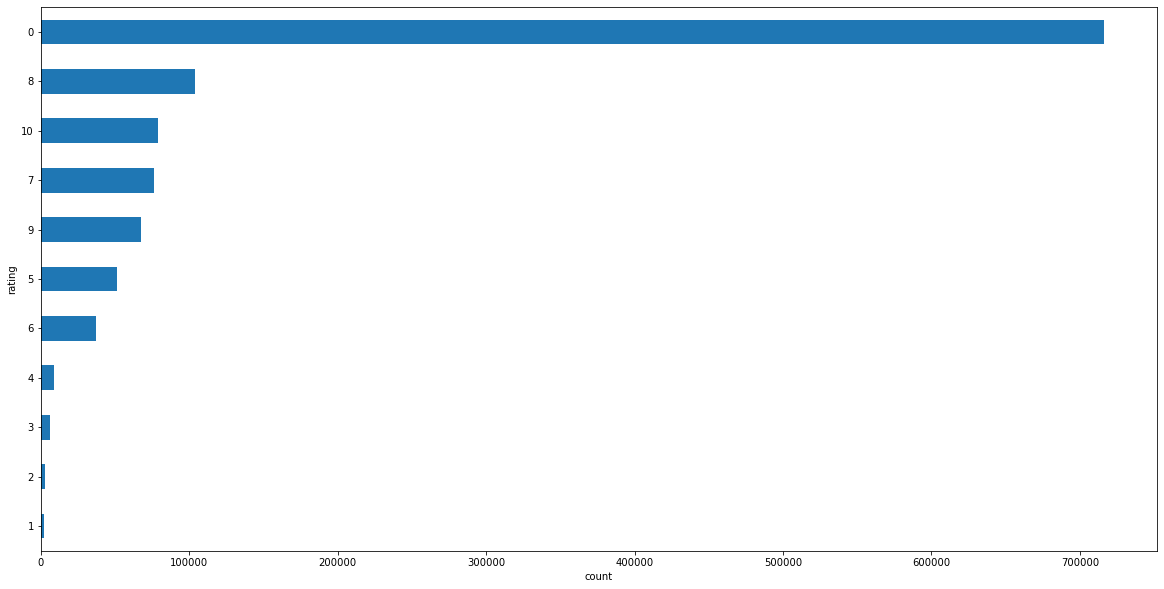

In [38]:
ratings.bookRating.value_counts(ascending = True).head(15).plot(kind='barh', figsize=(20, 10))
plt.xlabel("count")
plt.ylabel("rating")

### Corss check data

In [39]:
# filter the users who give ratings are also in the user table
ratings_filtered = ratings[ratings.userID.isin(users.userID)]
ratings_filtered.shape[0]/ ratings.shape[0]

1.0

In [40]:
# filter that the books in ratings are also in book table
ratings_filtered = ratings_filtered[ratings_filtered.ISBN.isin(books_filtered.ISBN)]
ratings_filtered.shape[0]/ratings.shape[0]

0.8845779192541182

# Check Sparsity

### Original size:

In [41]:
#size of the user to book matrix: 
print("Num of users: ", users.shape[0])
print("Num of books: ", books.shape[0])
print("size of the user-item matrix: ", users.shape[0] * books.shape[0])

Num of users:  278858
Num of books:  271360
size of the user-item matrix:  75670906880


In [42]:
#calculate the parsity of matrix
sparsity = 1 - ratings_filtered.shape[0] / (users.shape[0] * books.shape[0])
print("the rating matrix has ", str(sparsity*100) + " % of sparsity")

the rating matrix has  99.99865592994463 % of sparsity


### After filter books and users size:

In [43]:
#size of the user to book matrix: 
print("Num of users: ", ratings_filtered.userID.nunique())
print("Num of books: ", ratings_filtered.ISBN.nunique())
print("size of the user-item matrix: ", ratings_filtered.userID.nunique() * ratings_filtered.ISBN.nunique())

Num of users:  90679
Num of books:  265538
size of the user-item matrix:  24078720302


In [44]:
#calculate the parsity of matrix
sparsity = 1 - ratings_filtered.shape[0] / (ratings_filtered.userID.nunique() * ratings_filtered.ISBN.nunique())
print("the rating matrix has ", str(sparsity*100) + " % of sparsity")

the rating matrix has  99.99577606290018 % of sparsity


### implicit rating vs. explict ratings

In [45]:
# We dont know if 0 means user didnt rate or rated extremly low 
ratings_explicit = ratings_filtered[ratings_filtered.bookRating != 0]
ratings_implicit = ratings_filtered[ratings_filtered.bookRating == 0]

In [46]:
# ration of explicit ratings and implicit ratings
print("% explicit rating: ", round(ratings_explicit.shape[0]/ratings_filtered.shape[0] *100, 0))
print("% implicit rating: ", round(ratings_implicit.shape[0]/ratings_filtered.shape[0] *100, 0))


% explicit rating:  37.0
% implicit rating:  63.0


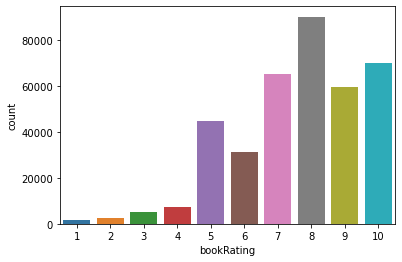

In [47]:
#for explicit 
sns.countplot(data=ratings_explicit , x='bookRating')
plt.show()

# Prepare user-item matrix

### Use explicit rating to bnuild matrix to 
- remove noisy pattern and computer resources due to large datasets, we will filter our dataframe of ratings to only popular movies.
    - the ratings by users rated >100 books
    - and the books have been rated >= 1000 times

In [48]:
ratings_explicit

,userID,ISBN,bookRating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
8,276744,038550120X,7
16,276747,0060517794,9
...,...,...,...
1149771,276704,0743211383,7
1149773,276704,0806917695,5
1149775,276704,1563526298,9
1149777,276709,0515107662,10


In [49]:
ratings_explicit.userID.nunique()

67073

In [50]:
user_count = ratings_explicit['userID'].value_counts()
user_count 
# not all users rated a lot of books

11676     6782
98391     5689
189835    1898
153662    1833
23902     1102
          ... 
114746    1   
114757    1   
114767    1   
114771    1   
276721    1   
Name: userID, Length: 67073, dtype: int64

In [51]:
user_count[user_count >= 100]

11676     6782
98391     5689
189835    1898
153662    1833
23902     1102
          ... 
208406    100 
36609     100 
169682    100 
26544     100 
95010     100 
Name: userID, Length: 438, dtype: int64

In [52]:
ratings_explicit = ratings_explicit[ratings_explicit['userID'].isin(user_count[user_count >= 100].index)]
ratings_explicit

,userID,ISBN,bookRating
1456,277427,002542730X,10
1458,277427,003008685X,8
1461,277427,0060006641,10
1465,277427,0060542128,7
1474,277427,0061009059,9
...,...,...,...
1147587,275970,185649814X,7
1147592,275970,1860462588,8
1147599,275970,1886411077,6
1147611,275970,3411086211,10


In [53]:
ratings_explicit['userID'].nunique()

438

In [54]:
book_count = ratings_explicit['ISBN'].value_counts()
book_count

0316666343    71
0385504209    47
059035342X    46
043935806X    46
0312195516    44
              ..
0762704845    1 
0767901991    1 
0767908236    1 
0804108633    1 
9626340762    1 
Name: ISBN, Length: 64967, dtype: int64

In [55]:
book_count[book_count >= 20]

0316666343    71
0385504209    47
059035342X    46
043935806X    46
0312195516    44
              ..
0671041789    20
044651652X    20
0446606812    20
0385335482    20
0345342968    20
Name: ISBN, Length: 100, dtype: int64

In [56]:
ratings_explicit = ratings_explicit[ratings_explicit['ISBN'].isin(book_count[book_count >= 20].index)]
ratings_explicit

,userID,ISBN,bookRating
1474,277427,0061009059,9
1522,277427,0316776963,8
1584,277427,0385504209,8
1601,277427,0399501487,9
1647,277427,0440224764,7
...,...,...,...
1140518,274301,0553280368,10
1140556,274301,068484267X,10
1146422,275970,014029628X,9
1146737,275970,0385722206,10


In [57]:
ratings_explicit.userID.nunique(), ratings_explicit.ISBN.nunique()

(385, 100)

### Creating ratings matrix from explicit ratings: NaN means this user hasn't rated this book

In [58]:
ratings_matrix = ratings_explicit.pivot(index='userID', columns='ISBN', values='bookRating')
userID = ratings_matrix.index
ISBN = ratings_matrix.columns
ratings_matrix.head()

ISBN,0060392452,0060928336,0060934417,0060976845,0060987103,0061009059,0064407667,014028009X,014029628X,0142001740,...,0743418174,0786868716,080410526X,0804106304,0805063897,0842329129,0971880107,1400031354,1400034779,1558744150
userID,,,,,,,,,,,,,,,,,,,,,
100459,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101606,NaN,8.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
print(ratings_matrix.shape)

(385, 100)


### Size of final matrix

In [60]:
#new size of the user to book matrix: 
print("Num of users in matrix: ", ratings_matrix.shape[0])
print("Num of books in matrix: ", ratings_matrix.shape[1])
print("size of the final user-item matrix: ", ratings_matrix.shape[0] * ratings_matrix.shape[0])

Num of users in matrix:  385
Num of books in matrix:  100
size of the final user-item matrix:  148225


### Fillna and transpose
- we can't use NaNs to train the model, since we need to use non-zero numbers to calculate the similarities. so we replace them by 0
- transpose the matrix for modeling

In [61]:
ratings_matrix.fillna(0, inplace = True)
ratings_matrix = ratings_matrix.astype(np.int32)

In [62]:
ratings_matrix

ISBN,0060392452,0060928336,0060934417,0060976845,0060987103,0061009059,0064407667,014028009X,014029628X,0142001740,...,0743418174,0786868716,080410526X,0804106304,0805063897,0842329129,0971880107,1400031354,1400034779,1558744150
userID,,,,,,,,,,,,,,,,,,,,,
100459,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100906,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101209,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101606,0,8,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101851,0,0,0,0,0,0,0,0,0,0,...,0,0,0,10,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96448,0,0,0,0,8,0,0,0,0,0,...,0,0,0,0,8,0,0,0,0,0
97754,0,0,0,0,0,0,0,0,0,0,...,5,0,0,0,0,0,0,0,0,0
97874,10,0,0,0,0,0,0,0,0,0,...,0,6,0,0,0,0,0,0,0,0


In [63]:
ratings_matrix.T

userID,100459,100906,101209,101606,101851,102647,102702,102967,104399,104636,...,94853,94951,95010,95359,95932,96448,97754,97874,98391,98758
ISBN,,,,,,,,,,,,,,,,,,,,,
0060392452,9,0,0,0,0,0,0,0,0,0,...,0,0,0,10,0,0,0,10,0,0
0060928336,0,0,0,8,0,0,0,0,0,0,...,0,0,0,0,8,0,0,0,0,0
0060934417,0,0,0,0,0,0,0,0,0,0,...,0,0,0,9,0,0,0,0,0,0
0060976845,0,0,0,6,0,0,0,0,0,0,...,0,0,0,7,0,0,0,0,0,0
0060987103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,8,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0842329129,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0971880107,0,0,0,0,0,0,0,0,0,0,...,6,0,0,0,0,0,0,0,0,0
1400031354,0,0,0,0,0,0,0,0,0,0,...,0,0,0,9,0,0,0,0,0,0


In [64]:
ratings_matrix_pivot = ratings_matrix.T
ratings_matrix_pivot

userID,100459,100906,101209,101606,101851,102647,102702,102967,104399,104636,...,94853,94951,95010,95359,95932,96448,97754,97874,98391,98758
ISBN,,,,,,,,,,,,,,,,,,,,,
0060392452,9,0,0,0,0,0,0,0,0,0,...,0,0,0,10,0,0,0,10,0,0
0060928336,0,0,0,8,0,0,0,0,0,0,...,0,0,0,0,8,0,0,0,0,0
0060934417,0,0,0,0,0,0,0,0,0,0,...,0,0,0,9,0,0,0,0,0,0
0060976845,0,0,0,6,0,0,0,0,0,0,...,0,0,0,7,0,0,0,0,0,0
0060987103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,8,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0842329129,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0971880107,0,0,0,0,0,0,0,0,0,0,...,6,0,0,0,0,0,0,0,0,0
1400031354,0,0,0,0,0,0,0,0,0,0,...,0,0,0,9,0,0,0,0,0,0


In [65]:
users[users.userID == "100459"]

,userID,Location,Age
100458,100459,"bay area, california, usa",38


In [66]:
books_filtered[books_filtered.ISBN == "0000913154"]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
254249,0000913154,The Way Things Work: An Illustrated Encyclopedia of Technology,C. van Amerongen (translator),1967,Simon &amp; Schuster


### Use book title instead of ISBN
- rating matrix join book table

In [67]:
ratings_matrix_pivot.index = ratings_matrix_pivot.join(books_filtered.set_index('ISBN'))['bookTitle']
# ratings_matrix_pivot = ratings_matrix_pivot.sort_index()
ratings_matrix_pivot

userID,100459,100906,101209,101606,101851,102647,102702,102967,104399,104636,...,94853,94951,95010,95359,95932,96448,97754,97874,98391,98758
bookTitle,,,,,,,,,,,,,,,,,,,,,
Stupid White Men ...and Other Sorry Excuses for the State of the Nation!,9,0,0,0,0,0,0,0,0,0,...,0,0,0,10,0,0,0,10,0,0
Divine Secrets of the Ya-Ya Sisterhood: A Novel,0,0,0,8,0,0,0,0,0,0,...,0,0,0,0,8,0,0,0,0,0
Bel Canto: A Novel,0,0,0,0,0,0,0,0,0,0,...,0,0,0,9,0,0,0,0,0,0
Little Altars Everywhere: A Novel,0,0,0,6,0,0,0,0,0,0,...,0,0,0,7,0,0,0,0,0,0
Wicked: The Life and Times of the Wicked Witch of the West,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,8,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Left Behind: A Novel of the Earth's Last Days (Left Behind No. 1),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Wild Animus,0,0,0,0,0,0,0,0,0,0,...,6,0,0,0,0,0,0,0,0,0
Tears of the Giraffe (No.1 Ladies Detective Agency),0,0,0,0,0,0,0,0,0,0,...,0,0,0,9,0,0,0,0,0,0


In [68]:
ratings_matrix_pivot = ratings_matrix_pivot.sort_index()
ratings_matrix_pivot

userID,100459,100906,101209,101606,101851,102647,102702,102967,104399,104636,...,94853,94951,95010,95359,95932,96448,97754,97874,98391,98758
bookTitle,,,,,,,,,,,,,,,,,,,,,
1st to Die: A Novel,0,0,0,0,0,0,0,0,0,10,...,0,0,0,8,0,0,0,0,0,0
A Is for Alibi (Kinsey Millhone Mysteries (Paperback)),0,0,0,0,0,0,0,0,0,9,...,0,0,0,4,0,0,0,0,0,0
A Painted House,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A Prayer for Owen Meany,0,0,0,0,0,7,0,0,0,0,...,0,0,0,10,0,0,0,10,0,0
A Time to Kill,10,0,0,0,9,10,0,0,0,10,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Where the Heart Is (Oprah's Book Club (Paperback)),0,0,0,9,0,0,0,0,0,10,...,0,0,0,0,0,0,0,0,0,0
White Oleander : A Novel,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
White Oleander : A Novel (Oprah's Book Club),0,0,0,0,0,0,0,0,0,8,...,0,0,0,6,0,0,0,0,0,0


In [69]:
ratings_matrix_pivot = ratings_matrix_pivot[~ratings_matrix_pivot.index.isnull()]
ratings_matrix_pivot

userID,100459,100906,101209,101606,101851,102647,102702,102967,104399,104636,...,94853,94951,95010,95359,95932,96448,97754,97874,98391,98758
bookTitle,,,,,,,,,,,,,,,,,,,,,
1st to Die: A Novel,0,0,0,0,0,0,0,0,0,10,...,0,0,0,8,0,0,0,0,0,0
A Is for Alibi (Kinsey Millhone Mysteries (Paperback)),0,0,0,0,0,0,0,0,0,9,...,0,0,0,4,0,0,0,0,0,0
A Painted House,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A Prayer for Owen Meany,0,0,0,0,0,7,0,0,0,0,...,0,0,0,10,0,0,0,10,0,0
A Time to Kill,10,0,0,0,9,10,0,0,0,10,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Where the Heart Is (Oprah's Book Club (Paperback)),0,0,0,9,0,0,0,0,0,10,...,0,0,0,0,0,0,0,0,0,0
White Oleander : A Novel,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
White Oleander : A Novel (Oprah's Book Club),0,0,0,0,0,0,0,0,0,8,...,0,0,0,6,0,0,0,0,0,0


In [70]:
ratings_matrix_pivot.index #book titles

Index(['1st to Die: A Novel',
       'A Is for Alibi (Kinsey Millhone Mysteries (Paperback))',
       'A Painted House', 'A Prayer for Owen Meany', 'A Time to Kill',
       'A Wrinkle In Time', 'All I Really Need to Know', 'American Gods',
       'Angela's Ashes: A Memoir', 'Angels &amp; Demons',
       'B Is for Burglar (Kinsey Millhone Mysteries (Paperback))',
       'Balzac and the Little Chinese Seamstress : A Novel',
       'Bel Canto: A Novel', 'Bridget Jones's Diary',
       'C Is for Corpse (Kinsey Millhone Mysteries (Paperback))',
       'Chicken Soup for the Woman's Soul (Chicken Soup for the Soul Series (Paper))',
       'Confessions of a Shopaholic (Summer Display Opportunity)', 'Congo',
       'Cruel &amp; Unusual (Kay Scarpetta Mysteries (Paperback))',
       'Divine Secrets of the Ya-Ya Sisterhood: A Novel', 'Empire Falls',
       'Fahrenheit 451', 'Four To Score (A Stephanie Plum Novel)',
       'Gerald's Game', 'Girl in Hyacinth Blue', 'Girl with a Pearl Earring',
    

In [71]:
# user ratings fot this book
loc = ratings_matrix_pivot.loc["Harry Potter and the Sorcerer's Stone (Book 1)"][:50]
loc

userID
100459    0 
100906    8 
101209    0 
101606    0 
101851    10
102647    0 
102702    0 
102967    0 
104399    0 
104636    0 
105028    0 
105517    0 
10560     0 
105979    0 
106007    0 
107784    0 
107951    0 
109574    0 
110912    0 
110934    0 
110973    0 
112001    0 
113270    0 
113519    0 
114368    5 
114868    0 
114988    0 
115002    0 
115003    0 
11676     8 
11993     0 
122429    0 
122793    0 
123094    0 
123608    8 
123883    0 
123981    0 
12538     0 
125519    0 
125774    0 
126492    0 
126736    0 
127200    0 
127359    0 
12824     0 
128835    0 
129074    0 
129716    0 
12982     0 
129851    0 
Name: Harry Potter and the Sorcerer's Stone (Book 1), dtype: int32

# Build Recommender:

#  Collaborative filter: KNN approach
- Item-based recommender (CF)- find similiar books and recommend to users
- Use KNN to find k most similar books
- Default params: 
    - metric = 'cosine'
    - algorithm = 'brute'
    - k = 5

In [72]:
global metric,k 
metric = 'cosine'
algorithm = 'brute'
k = 5 # number of recommendations
similarities = []
indices = []

In [73]:
model_knn = NearestNeighbors(metric = metric, algorithm = algorithm)
model_knn.fit(ratings_matrix_pivot.values)

NearestNeighbors(algorithm='brute', metric='cosine')

In [74]:
title = "Harry Potter and the Sorcerer's Stone (Book 1)"
ratings_matrix_pivot.loc[title].values

array([ 0,  8,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0,  0,  8,  0,  0,  0,  0,
        8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  7,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,
        0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [75]:
distances, indices = model_knn.kneighbors([ratings_matrix_pivot.loc[title].values], n_neighbors = k+1)
# k+1 bc returned value will be including itself

similarities = 1 - distances.flatten()

In [76]:
similarities

array([1.        , 0.64409766, 0.59783132, 0.44284619, 0.39254416,
       0.16745932])

In [77]:
indices

array([[35, 30, 34, 31, 32, 74]])

In [78]:
ratings_matrix_pivot.iloc[indices[0]].index.values

array(["Harry Potter and the Sorcerer's Stone (Book 1)",
       'Harry Potter and the Chamber of Secrets (Book 2)',
       'Harry Potter and the Prisoner of Azkaban (Book 3)',
       'Harry Potter and the Goblet of Fire (Book 4)',
       'Harry Potter and the Order of the Phoenix (Book 5)',
       'The Joy Luck Club'], dtype=object)

In [79]:
pd.DataFrame({
    'title'   : ratings_matrix_pivot.iloc[indices[0]].index.values,
    'similarities': similarities
}).sort_values(by='similarities', ascending=False)

,title,similarities
0,Harry Potter and the Sorcerer's Stone (Book 1),1.000000
1,Harry Potter and the Chamber of Secrets (Book 2),0.644098
2,Harry Potter and the Prisoner of Azkaban (Book 3),0.597831
3,Harry Potter and the Goblet of Fire (Book 4),0.442846
4,Harry Potter and the Order of the Phoenix (Book 5),0.392544
5,The Joy Luck Club,0.167459


### Create a function to output recommendations

In [80]:
# function to return recommended books 
def make_recommendation(matrix, model, k, title):
  try: 
    book = matrix.loc[title]
  except KeyError as e:
    print('Cannot find the book', e, 'in database!')
    return

  distance, indice = model.kneighbors([book.values], n_neighbors=k+1)
  similarities = 1 - distance.flatten()
  recommended_books = pd.DataFrame({
      'title'   : matrix.iloc[indice[0]].index.values,
      'similarities': similarities}).sort_values(by='similarities', ascending=False)

  return [recommended_books]

In [81]:
make_recommendation(ratings_matrix_pivot, model_knn, 5, "The Hobbit : The Enchanting Prelude to The Lord of the Rings")

[                                                                      title  \
 0  The Hobbit : The Enchanting Prelude to The Lord of the Rings               
 1  The No. 1 Ladies' Detective Agency (Today Show Book Club #8)               
 2  Stupid White Men ...and Other Sorry Excuses for the State of the Nation!   
 3  A Wrinkle In Time                                                          
 4  The Firm                                                                   
 5  Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))           
 
    similarities  
 0  1.000000      
 1  0.189115      
 2  0.154504      
 3  0.153445      
 4  0.146339      
 5  0.145799      ]

In [82]:
make_recommendation(ratings_matrix_pivot, model_knn, 5, "The Vampire Lestat (Vampire Chronicles, Book II)")

[                                                         title  similarities
 0  The Vampire Lestat (Vampire Chronicles, Book II)             1.000000    
 1  The Tale of the Body Thief (Vampire Chronicles (Paperback))  0.621567    
 2  Interview with the Vampire                                   0.505583    
 3  The Handmaid's Tale                                          0.270795    
 4  Watership Down                                               0.221334    
 5  A Time to Kill                                               0.220261    ]

# Content based model using NLP

### Distribution on part-of-speech tagging in book title

<!-- CC coordinating conjunction 
CD cardinal digit 
DT determiner 
EX existential there (like: “there is” … think of it like “there exists”) 
FW foreign word 
IN preposition/subordinating conjunction 
JJ adjective – ‘big’ 
JJR adjective, comparative – ‘bigger’ 
JJS adjective, superlative – ‘biggest’ 
LS list marker 1) 
MD modal – could, will 
NN noun, singular ‘- desk’ 
NNS noun plural – ‘desks’ 
NNP proper noun, singular – ‘Harrison’ 
NNPS proper noun, plural – ‘Americans’ 
PDT predeterminer – ‘all the kids’ 
POS possessive ending parent’s 
PRP personal pronoun –  I, he, she 
PRP$ possessive pronoun – my, his, hers 
RB adverb – very, silently, 
RBR adverb, comparative – better 
RBS adverb, superlative – best 
RP particle – give up 
TO – to go ‘to’ the store. 
UH interjection – errrrrrrrm 
VB verb, base form – take 
VBD verb, past tense – took 
VBG verb, gerund/present participle – taking 
VBN verb, past participle – taken 
VBP verb, sing. present, non-3d – take 
VBZ verb, 3rd person sing. present – takes 
WDT wh-determiner – which 
WP wh-pronoun – who, what 
WP$ possessive wh-pronoun, eg- whose 
WRB wh-adverb, eg- where, when -->

In [83]:
# CC coordinating conjunction 
# CD cardinal digit 
# DT determiner 
# EX existential there (like: “there is” … think of it like “there exists”) 
# FW foreign word 
# IN preposition/subordinating conjunction 
# JJ adjective – ‘big’ 
# JJR adjective, comparative – ‘bigger’ 
# JJS adjective, superlative – ‘biggest’ 
# LS list marker 1) 
# MD modal – could, will 
# NN noun, singular ‘- desk’ 
# NNS noun plural – ‘desks’ 
# NNP proper noun, singular – ‘Harrison’ 
# NNPS proper noun, plural – ‘Americans’ 
# PDT predeterminer – ‘all the kids’ 
# POS possessive ending parent’s 
# PRP personal pronoun –  I, he, she 
# PRP$ possessive pronoun – my, his, hers 
# RB adverb – very, silently, 
# RBR adverb, comparative – better 
# RBS adverb, superlative – best 
# RP particle – give up 
# TO – to go ‘to’ the store. 
# UH interjection – errrrrrrrm 
# VB verb, base form – take 
# VBD verb, past tense – took 
# VBG verb, gerund/present participle – taking 
# VBN verb, past participle – taken 
# VBP verb, sing. present, non-3d – take 
# VBZ verb, 3rd person sing. present – takes 
# WDT wh-determiner – which 
# WP wh-pronoun – who, what 
# WP$ possessive wh-pronoun, eg- whose 
# WRB wh-adverb, eg- where, when

<AxesSubplot:title={'center':'Top 10 Part-of-speech tagging in book title'}>

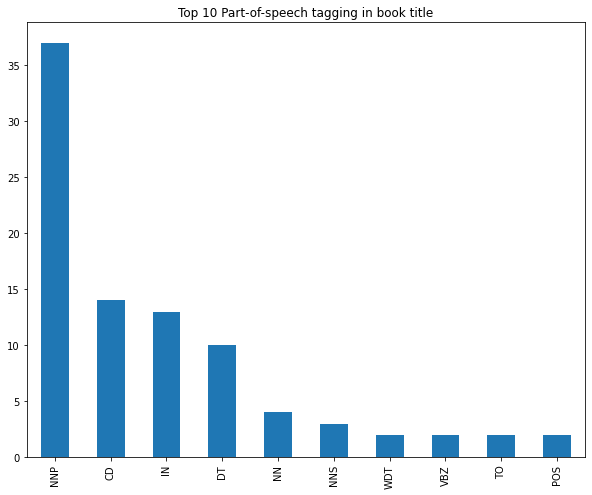

In [84]:
blob = TextBlob(str(books_filtered['bookTitle']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:10]
pos_df.plot(kind = 'bar', figsize=(10, 8),  title = "Top 10 Part-of-speech tagging in book title")

# NNP proper noun, singular – ‘Harrison’ 
# CD cardinal digit - 1,2,3...
# IN preposition/subordinating conjunction 
# DT determiner -  a member of a class of words used to modify nouns or noun equivalents
# NN noun, singular ‘- desk’ 

### Distribution on bigram in book title

<AxesSubplot:title={'center':'Bigram disribution for the top 25 words in the book title'}, ylabel='bigram'>

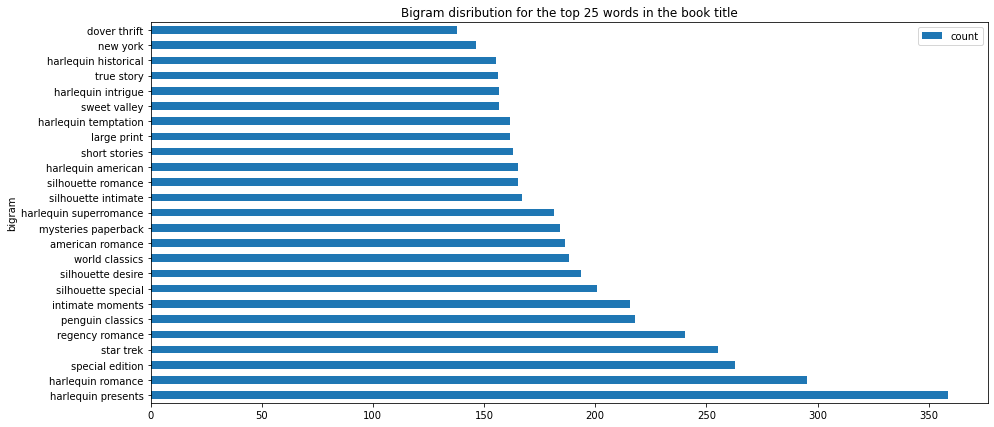

In [85]:
#Converting text descriptions into vectors using TF-IDF using Bigram
tf = TfidfVectorizer(ngram_range=(2, 2), stop_words='english', lowercase = True)
tfidf_matrix = tf.fit_transform(books_filtered['bookTitle'])
total_words = tfidf_matrix.sum(axis=0) 
#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)
#converting into dataframe 
bigram = pd.DataFrame(freq)
bigram.rename(columns = {0:'bigram', 1: 'count'}, inplace = True) 
#Taking first 20 records
bigram = bigram.head(25)
#Plotting the bigram distribution
bigram.plot(x ='bigram', y='count', kind = 'barh', title = "Bigram disribution for the top 25 words in the book title", figsize = (15,7), )

### Distribution on trigram in book title

<AxesSubplot:title={'center':'Trigram disribution for the top 25 words in the book title'}, ylabel='trigram'>

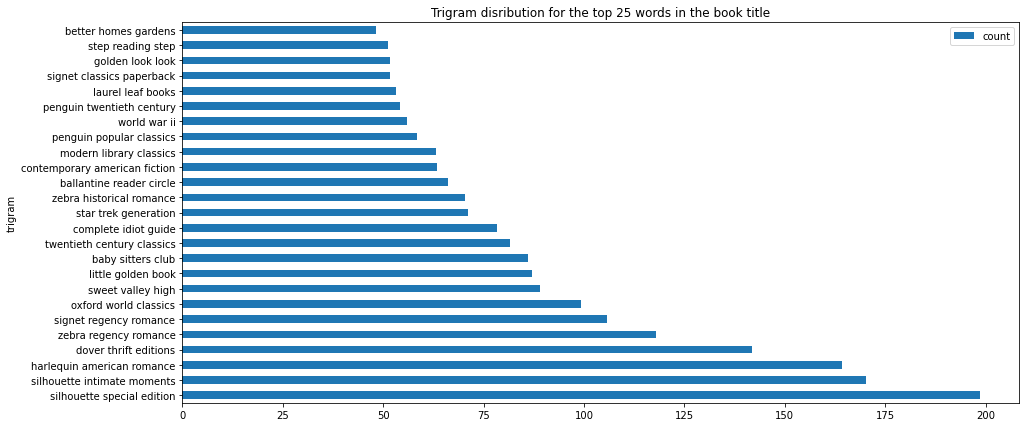

In [86]:
#Converting text descriptions into vectors using TF-IDF using Trigram
tf = TfidfVectorizer(ngram_range=(3, 3), stop_words='english', lowercase = True)
tfidf_matrix = tf.fit_transform(books_filtered['bookTitle'])
total_words = tfidf_matrix.sum(axis=0) 
#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)
#converting into dataframe 
trigram = pd.DataFrame(freq)
trigram.rename(columns = {0:'trigram', 1: 'count'}, inplace = True) 
#Taking first 20 records
trigram = trigram.head(25)
#Plotting the trigramn distribution
trigram.plot(x ='trigram', y='count', kind = 'barh', title = "Trigram disribution for the top 25 words in the book title", figsize = (15,7), )

In [87]:
books_filtered[books_filtered.bookTitle.str.contains("Harlequin Presents")]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
1013,0373123485,"On The Tycoon's Terms Do Not Disturb! (Harlequin Presents, 2348)",Sandra Field,2003,Harlequin
2565,0373123515,"The Spaniard's Woman Foreign Affairs (Harlequin Presents, 2351)",Diana Hamilton,2003,Harlequin
2566,0373123531,"The Greek Tycoon's Ultimatum The Greek Tycoons (Harlequin Presents, 2353)",Lucy Monroe,2003,Harlequin
5140,0373115458,Spirit Of Love (Harlequin Presents No. 11545),Emma Goldrick,1993,Harlequin
5556,0373111355,"Lifetime And Beyond (Harlequin Presents, 1135)",Alison Fraser,1988,Harlequin
...,...,...,...,...,...
269986,0373109067,"Diplomatic Affair (Harlequin Presents, No 906)",Claire Harrison,1986,Harlequin
269987,0373109423,"Shadow Princess (Harlequin Presents, No 942)",Sophie Weston,1986,Harlequin
270036,0373703198,Make No Mistake (Harlequin Presents # 319),Jeanne Triner,1988,Harlequin
270908,0373123892,"The Spaniard's Revenge (Harlequin Presents, 2389)",Susan Stephens,2004,Harlequin


### Clean book title

In [88]:
books_df = books_filtered
books_df

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company
...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm)
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books
271357,006008667X,Lily Dale : The True Story of the Town that Talks to the Dead,Christine Wicker,2004,HarperSanFrancisco
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press


In [89]:
# Function for removing NonAscii characters
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)
# Function for converting into lower case
def make_lower_case(text):
    return text.lower()
# Function for removing stop words
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text
# Function for removing punctuation
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text
#Function for removing the html tags
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)



# Applying all the functions in description and storing as a cleaned_desc
books_df["bookTitleNew"] = books_df.bookTitle.apply(_removeNonAscii)
books_df["bookTitleNew"] = books_df.bookTitleNew.apply(func = make_lower_case)
books_df["bookTitleNew"] = books_df.bookTitleNew.apply(func = remove_stop_words)
books_df["bookTitleNew"] = books_df.bookTitleNew.apply(func=remove_punctuation)
books_df["bookTitleNew"] = books_df.bookTitleNew.apply(func=remove_html)
books_df

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,bookTitleNew
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,classical mythology
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,clara callan
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,decision normandy
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,flu story great influenza pandemic 1918 search virus caused
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,mummies urumchi
...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),there s bat bunk five
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,one one hundred
271357,006008667X,Lily Dale : The True Story of the Town that Talks to the Dead,Christine Wicker,2004,HarperSanFrancisco,lily dale true story town talks dead
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,republic world s classics


### Function for recommending books based on Book title

In [103]:
# Function for recommending books based on Book title. It takes book title as an input.
def recommend(data, title, k):
    
    # Convert the index into series
    indices = pd.Series(data.index, index = data['bookTitle'])
    
    #Converting the book title into vectors and used bigram
    tf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df = 1, stop_words='english')
    tfidf_matrix = tf.fit_transform(data['bookTitleNew'])
    
    # Calculating the similarity measures based on Cosine Similarity
    sg = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    # Get the index corresponding to original_title       
    idx = indices[title]
    # Get the pairwsie similarity scores 
    sig = list(enumerate(sg[idx]))
    
    # Sort based on the second elem of the tuple: book title
    sig = sorted(sig, key = lambda x : x[1].all(), reverse=True)
    
    # Scores of the k most similar books 
    sig = sig[1:k+1]
    # Book indicies
    book_indices = [i[0] for i in sig]
   
    # Top n book recommendation
    rec = data[['bookTitle']].iloc[book_indices]
    print(rec)

In [96]:
recommend(books_df, "The Vampire Lestat (Vampire Chronicles, Book II)", 5)

                                       bookTitle
5330    The Night Listener : A Novel            
164078  The Night Listener: A Spoken Word Serial
234632  The Night Listener                      
0       Classical Mythology                     
1       Clara Callan                            


In [97]:
recommend(books_df, "The Hobbit : The Enchanting Prelude to The Lord of the Rings", 10)

                                                                                                       bookTitle
3590    Daughters of Britannia : The Lives and Times of Diplomatic Wives                                        
16476   Martina: The Lives and Times of Martina Navratilova                                                     
42955   Bob Dylan                                                                                               
53945   The Wizard of 4th Street (Questar)                                                                      
60294   Down the Highway: The Life of Bob Dylan                                                                 
66595   The Wizard of Sunset Strip (Wizard of 4th Street)                                                       
87631   No Direction Home: The Life and Music of Bob Dylan                                                      
93728   No Direction Home: The Life and Music of Bob Dylan                                      

# Future Work:
- cold start: cluster age and location and see what book the users like -> recommend to users who have the same age or location
- matrix factorization

# Links:

https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-1-knn-item-based-collaborative-filtering-637969614ea

https://medium.com/web-mining-is688-spring-2021/collaborative-book-recommendation-system-24a5aba2d2ed

https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0220129

https://www.sciencedirect.com/science/article/abs/pii/S0020025522002870